In [147]:
import os
import glob
import pathlib
import pandas as pd
import numpy as np
import tensorflow as tf
import keras
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [148]:
np.random.seed(1234)
tf.random.set_seed(1234)

## Extracting files


In [149]:
def extract_files(folder_path):
    csv_files = glob.glob(os.path.join(folder_path, "*.csv"))
    dataframes = []

    for file in csv_files:
        df = pd.read_csv(file)
        dataframes.append(df)
    return dataframes


extracted = extract_files("Topic_modelling")

In [150]:
alldata = pd.DataFrame()
for listitems in extracted:
    alldata = pd.concat([alldata, listitems])

## Feature extraction

In [151]:
alldata.head()

,headlines,description,content,url,category
0,Nirmala Sitharaman to equal Morarji Desai’s re...,With the presentation of the interim budget on...,"Sitharaman, the first full-time woman finance ...",https://indianexpress.com/article/business/bud...,business
1,"‘Will densify network, want to be at least no....","'In terms of market share, we aim to double it...",The merger of Tata group’s budget airlines Air...,https://indianexpress.com/article/business/avi...,business
2,Air India group to induct an aircraft every si...,Air India currently has 117 operational aircra...,The Air India group plans to induct one aircra...,https://indianexpress.com/article/business/avi...,business
3,Red Sea woes: Exporters seek increased credit ...,Rising attacks forced shippers to consider the...,Indian exporters have asked the central govern...,https://indianexpress.com/article/business/red...,business
4,Air India group to induct a plane every 6 days...,"Apart from fleet expansion, 2024 will also see...",The Air India group plans to induct one aircra...,https://indianexpress.com/article/business/avi...,business


In [152]:
targets = alldata["category"]
feature = alldata["content"]

In [153]:
print(targets.unique())

['business' 'education' 'entertainment' 'sports' 'technology']


In [154]:
maxlen = 100
embedding_dim = 100
max_words = 10000

classnames = {
    0 : 'Business',
    1 : 'Education',
    2 : 'Entertainment',
    3 : 'Sports',
    4 : 'Technology'
}

In [155]:
np.random.seed(1234)
tf.random.set_seed(1234)

from keras.preprocessing.sequence import pad_sequences
from tf_keras.preprocessing.text import Tokenizer


maxlen = 100
max_words = 10000

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(feature)
sequences = tokenizer.texts_to_sequences(feature)

word_index = tokenizer.word_index
data = pad_sequences(sequences, maxlen=maxlen)

In [130]:
print(data[2])

[   1 1523  138    4   85  712  115    9 1082 2736    3    9 4886    2
    1 1681  521    3  815  255    5   61  401 1519   24 6656   18    1
  756  225    9    4    1  409    5   36 1255  287   21 8408  401   28
    3 6355    2  858   62  619  690 3062  169    1  401   28 1189    3
  401   28  111    3 8139 2564 1977   28    2  858   62 1142 1255  169
    1  401   28  111 1189   91    1 2634 3642    5  401   28  111    3
 8139 2564    9 1210    1 1867    5  401   28    3 6355    9  313 5399
    4 2146]


### Prepare pretained word embeddings

In [156]:
embeddings_index = {}
f = open('glove.6B.100d.txt', encoding="utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype="float32")
    embeddings_index[word] = coefs
f.close()

print('found %s word vectors.' % len(embeddings_index))

found 400000 word vectors.


In [157]:
embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector


### Using pretrained word embeddings


In [158]:

np.random.seed(1234)
tf.random.set_seed(1234)

labels = np.asarray(targets)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

Shape of data tensor: (10000, 100)
Shape of label tensor: (10000,)


In [159]:
np.random.seed(1234)
tf.random.set_seed(1234)

VALIDATION_SPLIT = 0.25
TRAIN_SPLIT = 0.7

nb_training_samples = int(TRAIN_SPLIT * data.shape[0])
nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

#Train/Test sets
x_train, x_test = data[:nb_training_samples], data[nb_training_samples:]
y_train, y_test_real = labels[:nb_training_samples], labels[nb_training_samples:]

# validation sets
x_valid = x_train[-nb_validation_samples:]
y_valid = y_train[-nb_validation_samples:]

In [161]:
print(y_train[0:10])
#print(type(y_valid))

['education' 'business' 'sports' 'business' 'sports' 'sports' 'technology'
 'technology' 'sports' 'business']


In [162]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoder.fit(y_train)
y_train = encoder.transform(y_train)

In [163]:
print(y_train[0:10])

[1 0 3 0 3 3 4 4 3 0]


In [164]:
y_valid = encoder.transform(y_valid)
y_test = encoder.transform(y_test_real)
y_test_coms = encoder.transform(y_test_real)

In [165]:
y_train = keras.utils.to_categorical(y_train)
y_valid = keras.utils.to_categorical(y_valid)
y_test = keras.utils.to_categorical(y_test)

In [166]:
print(y_train[0:10])

[[0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]]


### Model with Word embeddings


In [167]:
np.random.seed(1234)
tf.random.set_seed(1234)

from keras.models import Sequential
from keras.layers import Embedding, Dense, Flatten, LSTM
from keras.layers import Conv1D, MaxPooling1D, Dropout

model = Sequential()
model.add(Embedding(input_dim=max_words,
                    output_dim=embedding_dim,
                    weights = [embedding_matrix],
                    trainable = False))
model.add(Conv1D(32, 7, activation = 'relu'))
model.add(MaxPooling1D(5))
model.add(Conv1D(32, 7, activation = 'relu'))
model.add(MaxPooling1D(5))
model.add(LSTM(32, recurrent_dropout=0.25, unroll=True))
model.add(Flatten())
model.add(Dense(units=128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dropout(0.5))
model.add(Dense(5, activation = 'softmax'))

model.build(input_shape=(None, 100))

model.summary()
model.save("model.keras")

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)         │ (None, 100, 100)       │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_10 (Conv1D)              │ (None, 94, 32)         │        22,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_10 (MaxPooling1D) │ (None, 18, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_11 (Conv1D)              │ (None, 12, 32)         │         7,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_11 (MaxPooling1D) │ (None, 2, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 32)             │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 128)            │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,050,757 (4.01 MB)

 Trainable params: 50,757 (198.27 KB)

 Non-trainable params: 1,000,000 (3.81 MB)

In [168]:
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

lr_scheduler = keras.callbacks.LearningRateScheduler(scheduler)

In [169]:
my_callbacks = [
    lr_scheduler,
    keras.callbacks.EarlyStopping(monitor="val_loss",
                                  patience=10, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                                      patience=10, min_lr=0.0001),
    keras.callbacks.ModelCheckpoint("model.keras", save_best_only=True)
]

In [170]:
from gc import callbacks
model.compile(
    optimizer = keras.optimizers.Nadam(),
    loss="categorical_crossentropy",
    metrics=['accuracy']
)

In [171]:
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=100,
                    validation_data = (x_valid, y_valid),
                    callbacks = my_callbacks)

Epoch 1/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.2664 - loss: 1.5500 - val_accuracy: 0.8360 - val_loss: 0.6559 - learning_rate: 0.0010
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6891 - loss: 0.7945 - val_accuracy: 0.9316 - val_loss: 0.2192 - learning_rate: 0.0010
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8740 - loss: 0.4353 - val_accuracy: 0.9520 - val_loss: 0.1519 - learning_rate: 0.0010
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9156 - loss: 0.2942 - val_accuracy: 0.9668 - val_loss: 0.1061 - learning_rate: 0.0010
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9356 - loss: 0.2297 - val_accuracy: 0.9612 - val_loss: 0.1198 - learning_rate: 0.0010
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9458 - loss: 0.1907 - val_accuracy: 0.9816 - val_loss: 0.0564 - learning_rate: 0.0010
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9581 - loss: 0.1554 - val_accu

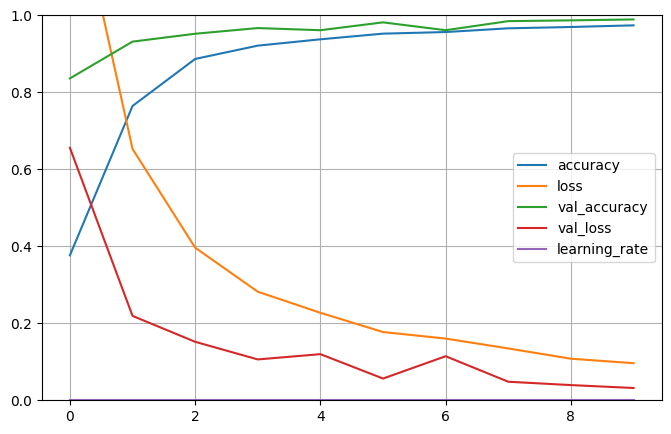

In [172]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [173]:
model.evaluate(x_test, y_test)

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9434 - loss: 0.3235


[0.3261246681213379, 0.9403333067893982]

In [ ]:
class_names = targets.unique()
class_names

array(['business', 'education', 'entertainment', 'sports', 'technology'],
      dtype=object)

In [174]:
X_new = x_test[:10]
y_pred = np.argmax(model.predict(X_new), axis=1)
print(np.array(class_names)[y_pred])

y_preds = np.argmax(model.predict(x_test), axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
['sports' 'sports' 'technology' 'business' 'technology' 'education'
 'technology' 'sports' 'business' 'sports']
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [175]:
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
cm = classification_report(y_test_coms, y_preds)
print(cm)

              precision    recall  f1-score   support

           0       0.91      0.94      0.93       584
           1       0.97      0.96      0.97       620
           2       0.98      0.93      0.96       586
           3       0.91      0.98      0.94       598
           4       0.93      0.89      0.91       612

    accuracy                           0.94      3000
   macro avg       0.94      0.94      0.94      3000
weighted avg       0.94      0.94      0.94      3000



Text(0.5, 1.0, 'Confusion Matrix Model with pretrained word embeddings')

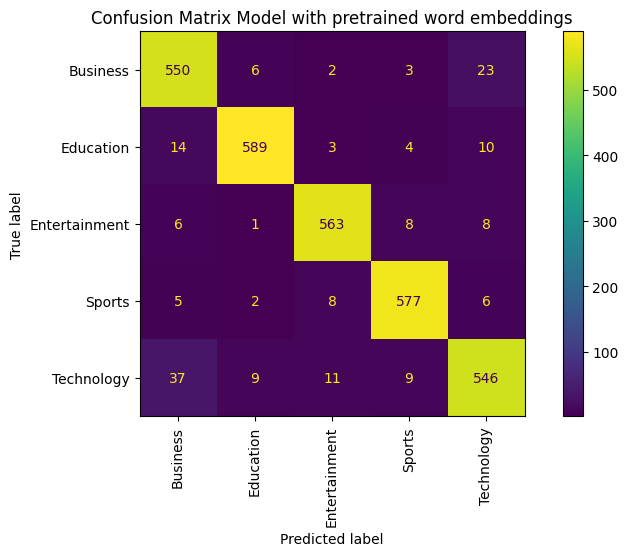

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
disp = ConfusionMatrixDisplay.from_predictions(y_test_coms, y_preds, ax=ax,
                                               xticks_rotation="vertical")
ax.xaxis.set_ticklabels(classnames.values())
ax.yaxis.set_ticklabels(classnames.values())
plt.title("Confusion Matrix Model with pretrained word embeddings")